In [ ]:
#| default_exp chem

# Chem

> Chemistry related functions


This notebook contains all chemistry-related functionality.  Here, a major part is functionality to generate isotope patterns and the averagine model. This is required for feature finding, where an isotope pattern is validated by being compared to its averagine model. We use the data structure `Isotopes` from constants to handle Isotopes. Next, we define the class `IsotopeDistribution` to calculate isotope distributions for a given Isotope. The core of the calculation is the function `fast_add`, which allows the fast estimation of isotope distributions. <br>
To calculate the isotope distribution for the averagine model, we define the function `get_average_formula`, which calculates the amino acid composition of the averagine molecule for the given mass.

:::{.callout-note}

Ideally, we would like to have constants such as isotopes as global variables to not overload functions with parameters. However, currently, numba is not able to handle typed dictionaries or jitclasses as globals. We, therefore, pass them as arguments.*

:::

In [ ]:
#| hide
from nbdev.showdoc import *

## IsotopeDistributions

The calculation of isotope distributions is based on the algorithm introduced in the paper _Calculation of isotope distributions in mass spectrometry. A trivial solution for a non-trivial problem_ by _Hugo Kubinyi_. 
A more detailed description of the algorithm can be found in the <a href="https://doi.org/10.1016/1044-0305(95)00017-8">paper</a>.

The implementation is a Python port of the Java version of the [proteomicore - implementation](https://github.com/fickludd/proteomicore/blob/c5e311c21c3191fc007798391ce77066531f1932/Proteins/src/main/java/se/lth/immun/chem/IsotopeDistribution.java) from Johan Teleman

In brief,  the approach avoids expanding polynomial expressions by combining precalculated patterns of hypothetical atom clusters and pruning low-intensity peaks. <br>
To calculate the isotope distribution for a given isotope, we define the function `dict_to_dist,` which accepts a dictionary of amino acids and returns the isotope distribution.

In [ ]:
#| export
from __future__ import annotations

import numpy as np
from numba import int32, float32, float64, njit, types
from numba.experimental import jitclass
from numba.typed import Dict

spec = [
    ('m0', float32),
    ('dm', int32),
    ('intensities', float64[:]),
]


#This class and the methods fast_add, numba_bin are tested in the wrapper function dict_to_dist
@jitclass(spec)
class IsotopeDistribution:
    """Class to represent isotope distributions.
    
    Attributes:
        m0 (int): the mono-isotopic mass.
        dm (int): number of isotopes.
        intensities (np.ndarray): isotope intensities.

    Methods:
        add: add another isotope distribution.
        copy: create a copy of the current isotope distribution.
        mult: multiply the current isotope distribution.

    """    

    def __init__(self):
        self.m0 = 0
        self.dm = 1
        self.intensities = np.array([1.0])

    def add(self, x:IsotopeDistribution):
        """Add another isotope distribution.

        Args:
            x (IsotopeDistribution): IsotopeDistribution.
        """        
        self.m0, self.dm, self.intensities = fast_add(
            self.m0, self.dm, self.intensities, x.m0, x.dm, x.intensities
        )

    def copy(self) -> IsotopeDistribution:
        """Copies the current isotope distribution.

        Returns:
            IsotopeDistribution: A copy of the current isotope distribution.
        """   
        i = IsotopeDistribution()
        i.m0 = self.m0
        i.dm = self.dm
        i.intensities = self.intensities

        return i

    def mult(self, n:int) -> IsotopeDistribution:
        """Multiplies the current isotope distribution.

        Args:
            n (int): Multiplication factor.

        Returns:
            IsotopeDistribution: A multiplied version of the current isotope distribution.
        """        
        binary = numba_bin(n)

        if n == 1:
            return self.copy()
        else:
            i = IsotopeDistribution()

            multiples = self.copy()

            for count in binary[::-1]:
                if count == 1:
                    i.add(multiples)
                multiples.add(multiples)

            return i


@njit
def fast_add(m0: int, dm0: int, int0: np.ndarray, m1: int, dm1: int, int1: np.ndarray, prune_level: float=0.000001) ->(int, int, np.ndarray):
    """Helper function to quickly add isotope patterns.

    Args:
        m0 (float): the mono-isotopic mass of the first isotope distribution.
        dm0 (int): the number of isotope intensities in the first isotope distribution.
        int0 (np.ndarray:float): the intensity pattern of the first isotope distribution.
        m1 (float): the mono-isotopic mass of the second isotope distribution.
        dm1 (int): the number of isotope intensities in the second isotope distribution.
        int1 (np.ndarray:float): the intensity pattern of the second isotope distribution.
        prune_level (float): Precision threshold. Defaults to 0.000001.


    Returns:
        int: Mass of new pattern.
        int: Number of isotopes in new pattern.
        np.ndarray: Intensity of new pattern.

    """
    m0 += m1

    ni = np.zeros(dm0 + dm1 - 1)
    for i in range(dm0):
        for j in range(dm1):
            ni[i + j] += int0[i] * int1[j]

    dm0 += dm1 - 1

    int0 = ni / np.max(ni)

    while ni[dm0 - 1] < prune_level:
        dm0 -= 1

    return m0, dm0, int0

@njit
def numba_bin(decimal:int)->list:
    """Numba compatible function to convert a decimal number to a binary (list).

    Args:
        decimal (int): Decimal number.

    Returns:
        list: Number in binary.
    """    

    binary = []

    while decimal != 0:
        bit = int(decimal % 2)
        binary.insert(0,bit)
        decimal = int(decimal/2)

    return binary

@njit
def dict_to_dist(counted_AA:Dict, isotopes:Dict)->IsotopeDistribution:
    """Function to convert a dictionary with counts of atoms to an isotope distribution.

    Args:
        counted_AA (Dict): Numba-typed dict with counts of atoms.
        isotopes (Dict): Numba-typed lookup dict with isotopes.

    Returns:
        IsotopeDistribution: The calculated isotope distribution for the chemical compound. 
    """    

    dist = IsotopeDistribution()
    for AA in counted_AA.keys():

        x = IsotopeDistribution()
        x.add(isotopes[AA])
        x = x.mult(counted_AA[AA])

        dist.add(x)

    return dist

In [ ]:
#| hide

from alphapept.constants import isotopes

In [ ]:
#| hide

def test_dict_to_dist():    

    abundances = np.array([58.83,0.18,100,0.29,81.29,0.22,42.05,0.11,15.54,0.04,4.36,0.01,0.97,0.17,0.03])/100

    counted_AA = Dict.empty(key_type=types.unicode_type, value_type=types.int64)
    counted_AA["K"] = 23
    counted_AA["I"] = 22
    dist = dict_to_dist(counted_AA, isotopes)    
    
    rmse = np.mean(np.sqrt((dist.intensities[: len(abundances)] - abundances) ** 2))
    
    assert rmse < 0.05
    
test_dict_to_dist()

One can compare the implementation to the algorithm with plotting values from the paper against the own results. Example $K_{23}I_{22}$ is Table 2 from the paper.

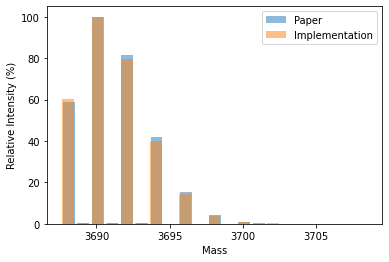

In [ ]:
import matplotlib.pyplot as plt
 
from alphapept.constants import isotopes
import numpy as np
from numba.typed import Dict
from numba import types

# Example from paper:
mass = 3688.1
abundances = np.array([58.83,0.18,100,0.29,81.29,0.22,42.05,0.11,15.54,0.04,4.36,0.01,0.97,0.17,0.03])/100
masses = [mass + i for i in range(len(abundances))]

# Calculation with own function
counted_AA = Dict.empty(key_type=types.unicode_type, value_type=types.int64)
counted_AA["K"] = 23
counted_AA["I"] = 22
dist = dict_to_dist(counted_AA, isotopes)
masses_ = [dist.m0 + i for i in range(len(dist.intensities))]

# Plot 
masses = [mass + i for i in range(len(abundances))]
plt.bar(masses, abundances*100, alpha=0.5, label='Paper')
plt.bar(masses_, dist.intensities*100, alpha=0.5, label='Implementation')
plt.xlabel('Mass')
plt.ylabel('Relative Intensity (%)')
plt.legend()
plt.show()

## Averagine

The averagine model is based on [Senko et al.](https://www.sciencedirect.com/science/article/pii/1044030595000178). We define the function `get_average_formula` to calculate a dictionary with averagine masses.

In [ ]:
#| export
from numba.typed import Dict
from numba import types, njit
from alphapept.constants import averagine_avg

@njit
def get_average_formula(molecule_mass:float, averagine_aa:Dict, isotopes:Dict, sulphur:bool=True)->Dict:
    """Function to calculate the averagine formula for a molecule mass.

    Args:
        molecule_mass (float): Input molecule mass for which the averagine model should be calculated.
        averagine_aa (Dict): Numba-typed dictionary with averagine masses. See alphapept.constants.averagine_aa.
        isotopes (Dict): Numba-typed lookup dict with isotopes.
        sulphur (bool, optional): Flag to consider sulphur. Defaults to True.

    Raises:
        NotImplementedError: If mode w/o sulphur is selected.

    Returns:
        Dict: Numba-typed dict with averagine composition.
    """    


    if sulphur:
        averagine_units = molecule_mass / averagine_avg
    else:
        raise NotImplementedError("Mode w/o sulphur is not implemented yet")

    counted_AA = Dict.empty(key_type=types.unicode_type, value_type=types.int64)

    final_mass = 0

    # Calculate integral mnumbers of atoms
    for AA in averagine_aa.keys():
        counted_AA[AA] = int(np.round(averagine_units * averagine_aa[AA]))
        final_mass += counted_AA[AA] * isotopes[AA].m0

    # Correct with H atoms
    h_correction = int(np.round((molecule_mass - final_mass) / isotopes["H"].m0))
    counted_AA["H"] += h_correction

    return counted_AA

In [ ]:
from alphapept.constants import averagine_aa, averagine_avg

In [ ]:
molecule_mass = 300
print(get_average_formula(molecule_mass, averagine_aa, isotopes, sulphur=True))

{C: 13, H: 24, N: 4, O: 4, S: 0}


In [ ]:
#| hide
def test_get_average_formula():
    for molecule_mass in [100, 200, 300, 400, 500]:
        average_formula = get_average_formula(
            molecule_mass, averagine_aa, isotopes, sulphur=True
        )
        mass = np.sum(
            [average_formula[AA] * isotopes[AA].m0 for AA in average_formula.keys()]
        )
        assert np.abs(mass - molecule_mass) < isotopes["H"].m0
        
test_get_average_formula()

To directly calculate the isotope distribution of a molecule mass based on the averagine model, we define the wrapper function `mass_to_dist`.

In [ ]:
#| export
from alphapept.constants import mass_dict
ISOTOPE_MASS = mass_dict['delta_M']
@njit
def mass_to_dist(molecule_mass: float, averagine_aa:Dict, isotopes:Dict)-> (np.ndarray, np.ndarray):
    """Function to calculate an isotope distribution from a molecule mass using the averagine model.

    Args:
        molecule_mass (float, averagine_aa): input molecule mass.
        averagine_aa (Dict): Numba-typed dictionary with averagine masses.
        isotopes (Dict): Numba-typed lookup dict with isotopes.

    Returns:
        np.ndarray: isotope masses.
        np.ndarray: isotope intensity.
    """    
    counted_AA = get_average_formula(molecule_mass, averagine_aa, isotopes)

    dist = dict_to_dist(counted_AA, isotopes)

    masses = np.array([dist.m0 + i*ISOTOPE_MASS for i in range(len(dist.intensities))])
    ints = dist.intensities

    return masses, ints

In [ ]:
print(mass_to_dist(300, averagine_aa, isotopes))

(array([300.18252563, 301.18539427, 302.18826291, 303.19113155,
       304.19400019, 305.19686883]), array([1.00000000e+00, 1.59501684e-01, 2.01508986e-02, 1.86370995e-03,
       1.39934810e-04, 8.55900106e-06]))


We can use this to plot isotope distributions for a given mass.

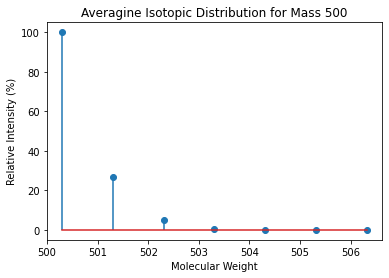

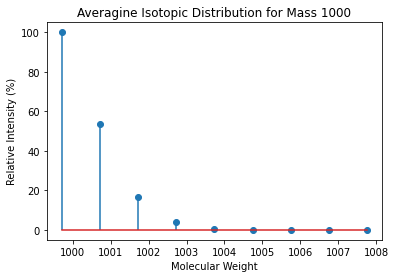

In [ ]:
def plot_averagine(mass, averagine_aa, isotopes):

    masses, intensity = mass_to_dist(mass, averagine_aa, isotopes)
    plt.title("Averagine Isotopic Distribution for Mass {}".format(mass))
    plt.stem(masses, intensity*100, use_line_collection=True)
    plt.ylabel("Relative Intensity (%)")
    plt.xlabel("Molecular Weight")
    plt.show()

plot_averagine(500, averagine_aa, isotopes)
plot_averagine(1000, averagine_aa, isotopes)

## Mass Calculations
`calculate_mass`: This function allows to calculate the precursor mass from the monoisotopic m/z and the charge.

In [ ]:
#| export
from alphapept.constants import mass_dict

M_PROTON = mass_dict['Proton']

@njit
def calculate_mass(mono_mz:float, charge:int) -> float:
    """Calculate the precursor mass from mono mz and charge.

    Args:
        mono_mz (float): mono m/z.
        charge (int): charge.

    Returns:
        float: precursor mass.
    """    
    prec_mass = mono_mz * abs(charge) - charge * M_PROTON

    return prec_mass

In [ ]:
mz = 300
charge = 2

print(calculate_mass(mz, charge))

597.98544706626


In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()